# Домашнее задание: аугментация датасета

Домашнее задание состоит из трех частей:
1. Загрузка и предобработка [датасета](https://www.kaggle.com/datasets/vencerlanz09/healthy-and-bleached-corals-image-classification).
Ожидаемый результат - numpy массив images с изображениями из датасета, приведенными к единому размеру: 100х100x3 с сохранением соотношения сторон.
2. Написание классов-оберток для функций преобразований, чтобы осущесвлять случайные преобразования. Ожидаемый результат - корректно работающие обертки для любых 3 цветовых преобразований, любых 5 геометических, 1 наложения шума или сглаживания на выбор.
3. Применение аугментации. Ожидаемый результат - 5 аугментированных изображений.

In [1]:
import cv2
import glob
import numpy as np
import random
from abc import ABC 
from matplotlib import pyplot as plt
from typing import Literal
import skimage

In [2]:
# Helpfull

def show_img(img, ax, title, **kwargs):
    ax.imshow(img[..., ::-1], **kwargs)
    ax.axis('off')

    try:
        ax.set_title(title)
    except:
        ax.title(title)


def print_imgs(imgs, coords=None):
    """
    Return randow 10 pictures from imgs
    or just 10 images from coords
    """
    if coords and len(coords) != 10:
        raise 'I expect just 10 coords'
    elif coords is None:
        coords = random.sample(range(0, imgs.shape[0]), 10)

    f, axes = plt.subplots(2, 5, figsize=(15, 5))

    g_i = 0

    for i in range(2):
        for j in range(5):
            show_img(imgs[coords[g_i]], axes[i][j], f'img_{g_i}')
            g_i += 1

    plt.show()


BORDER_MODE = {
    'default': cv2.BORDER_CONSTANT,
    'copy': cv2.BORDER_REPLICATE,
    'mirror': cv2.BORDER_REFLECT,
    'repead': cv2.BORDER_WRAP
}

## Загрузка и предобработка датасета

! Unzip the hw1 archive before executing !

In [ ]:
# Get images' paths

main_path = ... # PASS YOUR PATH

img_paths = [
    img_path for img_path in glob.glob(main_path, recursive=True)
    if img_path.split('.')[-1] in ['jpg', 'jpeg', 'png', 'bmp']
]

print('Images count:', len(img_paths))
print('Images example:')
img_paths[:10]

Images count: 923
Images example:


['../../main_git_repo/classic_cv/sources/hw1/bleached_corals/14840328913_5728092dd8_o.jpg',
 '../../main_git_repo/classic_cv/sources/hw1/bleached_corals/28897334291_62c5845484_o.jpg',
 '../../main_git_repo/classic_cv/sources/hw1/bleached_corals/8514121744_567b5db215_o.jpg',
 '../../main_git_repo/classic_cv/sources/hw1/bleached_corals/9408998752_c88cbb2388_o.jpg',
 '../../main_git_repo/classic_cv/sources/hw1/bleached_corals/11333883796_e74aa9bd17_o.jpg',
 '../../main_git_repo/classic_cv/sources/hw1/bleached_corals/3138325955_a81720c19b_o.jpg',
 '../../main_git_repo/classic_cv/sources/hw1/bleached_corals/33932503076_79a24a44bb_o.jpg',
 '../../main_git_repo/classic_cv/sources/hw1/bleached_corals/8728295760_44aeb65001_o.jpg',
 '../../main_git_repo/classic_cv/sources/hw1/bleached_corals/14986419582_3585068d13_b.jpg',
 '../../main_git_repo/classic_cv/sources/hw1/bleached_corals/5975859265_71954f54a2_o.jpg']

In [4]:
# Write images

target_size = (100, 100)

images = np.array([
    cv2.resize(cv2.imread(img_path), target_size)
    for img_path in img_paths
])

images.shape

(923, 100, 100, 3)

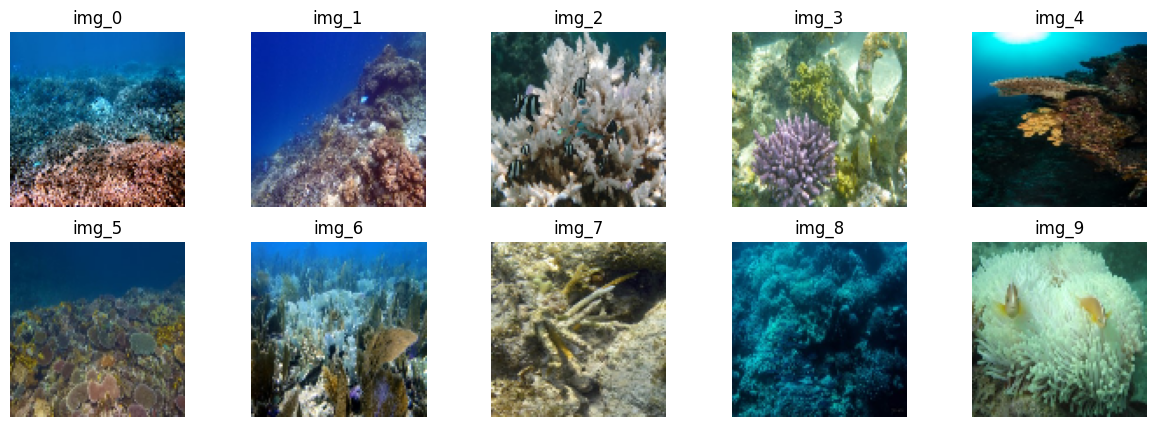

In [5]:
# Print random 5 origin images

print_imgs(images)

## Написание оберток для функций преобразований

In [6]:
def resize(img, size, save_ar=True):
    old_h, old_w = img.shape[:2]
    new_h, new_w = size

    # Выбор интерполяции
    if old_h > new_h or old_w > new_w:
        # выберите предпочтительную интерполяцию для уменьшения изображения
        interp = cv2.INTER_AREA
    else:
        # выберите предпочтительную интерполяцию для увеличения изображения
        interp = cv2.INTER_NEAREST

    if save_ar:  # Если нужно сохранить соотношение сторон
        # тензор нулей, в который нужно вставить масштабированное изображение
        new_img = np.zeros((new_h, new_w, img.shape[2]), dtype=img.dtype)
        ar = old_h / old_w
        if ar > 1:  # вертикальное изображение
            factor = new_h / old_h
            resize_h = new_h
            resize_w = int(old_w * factor)
        else:  # горизонтальное изображение
            factor = new_w / old_w
            resize_w = new_w
            resize_h = int(old_w * factor)

        resized_img = cv2.resize(
            img, (resize_h, resize_w), interpolation=interp)

        # Расчет координат, чтобы масштабированное изображение вставилось в центр:
        # 1. Вычисляет, сколько свободного пространства осталось по вертикали и горизонтали (разница между значениями).
        # 2. Делим на 2, чтобы одинаково распределить пустое пространство сверху и снизу — так изображение окажется по центру.
        # 3. Преобразуем результат к целому числу, потому что индексы массива должны быть целыми.
        # 4. Если вдруг масштабированное изображение оказалось больше холста (например, из-за округления), чтобы не получить отрицательные индексы, берём максимум между рассчитанным значением и 0.
        start_ymin = max(int((new_h - resize_h) / 2), 0)
        start_xmin = max(int((new_w - resize_w) / 2), 0)

        new_img[start_ymin:start_ymin + resize_h,
                start_xmin:start_xmin + resize_w] = resized_img
    else:  # Если не нужно сохранять соотношение сторон
        new_img = cv2.resize(img, (new_h, new_w))

    return new_img


def noise(
    img,
    mode: Literal['gaussian', 'poisson', 'salt', 'pepper', 's&p'],
    amount: float = None
):
    if amount:
        try:
            new_img = skimage.util.random_noise(img, mode=mode, amount=amount)
        except:
            try:
                new_img = skimage.util.random_noise(img, mode=mode, var=amount)
            except:
                new_img = skimage.util.random_noise(img, mode=mode)
    else:
        new_img = skimage.util.random_noise(img, mode=mode)

    new_img = (new_img * 255).astype('uint8')

    return new_img


class ColorChanges:
    @classmethod
    def change_hue(cls, img, delta):
        """
        Изменение оттенка: изменяется добавлением к оригинальному оттенку
        любого числа delta в интервале от 0 до 180. Потом берется от 
        результата остаток от деления на 180, чтобы получить новый оттенокю
        """
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # Индекс оттенка - 0
        h = hsv[:, :, 0]

        h_new = (h+delta) % 180

        hsv[:, :, 0] = h_new

        new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        return new_img

    @classmethod
    def change_saturation(cls, img, factor):
        """
        Изменение насыщенности: изменяется умножением на положительный фактор.
        Фактор от 0 до 1 уменьшает насыщенность, фактор больше 1 увеличивает
        насыщенность. Значение этого канала должно лежать в интервале от 0 до 255
        """
        # Индекс насыщенности - 1
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Выделение канала s - насыщенности с указанием, что число может быть больше 255 (float32)
        # чтобы умножение на большой фактор не приводило к переполнению переменной s
        s = hsv[:, :, 1].astype('float64')

        # обрезаем полученное число насыщенности методом np.clip,
        # чтобы оно гарантированно осталось в интервале от 0 до 255
        s_new = np.clip(s*factor, 0, 255)

        # число возвращается из float32 в uint8
        hsv[:, :, 1] = s_new.astype('uint8')

        new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        return new_img

    @classmethod
    def change_brightness(cls, img, factor):
        """
        Изменение яркости: может изменяться как умножением на фактор,
        так и добавлением некоторой дельты. Значение этого канала
        должно лежать в интервале от 0 до 255.
        """
        # Индекс яркости - 2
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        v = hsv[:, :, 2].astype('float64')

        v_new = np.clip(v * factor, 0, 255)

        hsv[:, :, 2] = v_new.astype('uint8')

        new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        return new_img

    @classmethod
    def change_contrast(cls, img, factor):
        """
        Изменение контрастности: усиливает разницу между наиболее 
        тёмными и наиболее светлыми пикселями. Граница между светлыми
        и тёмными пикселями проходит по значению 127,5 — это среднее
        между 0 и 255
        """
        # вычесть из всех пикселей изображения среднее 127,5,
        # тогда все светлые пиксели останутся положительными
        # числами, а тёмные станут отрицательными.
        new_img = img - 127.5

        # если фактор больше 1, разница между положительными и
        # отрицательными числами увеличится, если фактор от
        # 0 до 1 — уменьшится.
        new_img *= factor

        # Добавить к числам среднее, чтобы снова превратить
        # числа в значения пикселей и убедиться, что все пиксели
        # лежат в интервале от 0 до 255 с помощью функции np.clip
        new_img = np.clip(new_img + 127.5, 0, 255).astype('uint8')

        return new_img

    @classmethod
    def change_gamma(cls, img, gamma):
        """
        Изменение гаммы: нелинейное преобразование яркости каждого пикселя.
        Пиксели переводятся из интервала от 0 до 255 к интервалу от 0 до 1,
        то есть делятся на 255. После изменения — умножаются обратно.
        С параметром от 0 до 1 изображение будет выглядеть темнее оригинала,
        с параметром больше 1 — светлее:

        newPix = ( oldPx / 255) ^ (1/gamma) * 255
        """

        inv_gamma = 1.0 / gamma

        # создаем таблицу, где каждому значению пикселя от 0 до 255
        # приводится в соответствие новое значение пикселя, рассчитанное
        # по формуле с учётом параметра гамма
        table = np.array([
            ((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)
        ]).astype('uint8')

        # переводим прежние значения пикселей в новые по таблице с
        # помощью функции cv2.LUT (look-up table)
        new_img = cv2.LUT(img, table)

        return new_img


class GeometricChanges:
    @classmethod
    def flip(cls, img, mode: Literal['h', 'v']):
        """
        отражение, два режима: 
            'h': горизонтальный
            'v': вертикальный
        """
        if mode == 'h':
            new_img = img[:, ::-1]
        else:
            new_img = img[::-1]

        return new_img

    @classmethod
    def crop(
        cls, img, x, y, h, w, mode: Literal['trim', 'cut']
    ):
        """ 
        вырезать:
            mode:
                'trim': обрезать
                'cut': вырезать
            x and y: начальная кардината вырезаемого куска
            h and w: размер вырезаемого куска
        """

        x, y, h, w = int(x), int(y), int(h), int(w)

        if mode == 'trim':
            croped_img = img[y:y+h, x:x+w]

            new_img = np.zeros(img.shape, dtype='uint8')
            new_img[y:y+h, x:x+w] = croped_img
        else:
            new_img = img.copy()
            new_img[y:y+h, x:x+w] = 0

        return new_img

    @classmethod
    def zoom_in(cls, img, factor):
        """ 
        приближение: фактор должен быть больше 1
        """
        img_h, img_w = img.shape[:2]

        # Расчёт матрицы преобразования изображения
        # Для этого указан центр (что именно приближать)
        # Угол поворота - 0, так как поворот не нужен
        # Масштаб - фактор
        m_zoom = cv2.getRotationMatrix2D(
            center=(img_h / 2, img_w / 2),
            angle=0,
            scale=factor
        )

        # Приближение изображения и размещение в тензоре
        # размера изначального изображения с помощью
        # аффинного преобразования
        new_img = cv2.warpAffine(
            img, M=m_zoom, dsize=(img_w, img_h)
        )

        return new_img

    @classmethod
    def zoom_out(
        cls, 
        img,
        factor,
        mode: Literal['default', 'copy', 'mirror', 'repead'] = 'default'
    ):
        """
        отдаление: фактор должен быть от 0 до 1
        """

        img_h, img_w = img.shape[:2]

        m_zoom = cv2.getRotationMatrix2D(
            center=(img_h / 2, img_w / 2),
            angle=0,
            scale=factor
        )

        new_img = cv2.warpAffine(
            img,
            M=m_zoom,
            dsize=(img_w, img_h),
            borderMode=BORDER_MODE[mode]
        )

        return new_img

    @classmethod
    def rotate(
        cls, 
        img,
        angle,
        mode: Literal['default', 'copy', 'mirror', 'repead'] = 'default'
    ):
        """ 
        поворот
        """
        img_h, img_w = img.shape[:2]

        m_rotate = cv2.getRotationMatrix2D(
            center=(img_h / 2, img_w / 2),
            angle=angle,
            scale=1
        )

        new_img = cv2.warpAffine(
            img,
            M=m_rotate,
            dsize=(img_w, img_h),
            borderMode=BORDER_MODE[mode]
        )

        return new_img

    @classmethod
    def translate(
        cls, 
        img,
        dx,
        dy,
        mode: Literal['default', 'copy', 'mirror', 'repead'] = 'default'
    ):
        """
        трансляция - смещение по вертикальным или горизонтальным осям:
            dx: смещение по горизонтали
                положительное - вправо; отрицательное - влево
            dy: смещение по вертикали
                положительное - вниз; отрицательное - наверх
        """

        img_h, img_w = img.shape[:2]

        dx_abs = int(round(img_w * dx))
        dy_abs = int(round(img_h * dy))

        # За параметры линейного преобразования берем единичеую матрицу,
        # поскольку у нас нет никакой ротации изображения (сохраняем его
        # в исходном виде). Для смещения меняем tx и ty наши дельты
        m_translate = np.float32([
            [1, 0, dx_abs],
            [0, 1, dy_abs]
        ])

        new_img = cv2.warpAffine(
            img,
            M=m_translate,
            dsize=(img_w, img_h),
            borderMode=BORDER_MODE[mode]
        )

        return new_img

    @classmethod
    def change_perspective(
        cls, 
        img,
        perspective_points,
        mode: Literal['default', 'copy', 'mirror', 'repead'] = 'default'
    ):
        """
        изменение перспективы: 4 точки должны лежать в пределах изображения

        perspective_points[0]: top-left: куда переместить левый верхний угол
        perspective_points[1]: top-right: куда переместить правый верхний угол
        perspective_points[2]: bottom-left: куда переместить левый нижний угол
        perspective_points[3]: bottom-right: куда переместить правый нижний угол
        
        x->
          -------------------------------------
          | top-left               top-right
          |
        ^ |
        | | bottom-left            bottom-right
        y |
        
        """
        img_height, img_width = img.shape[:2]

        # Выбор точек, которые задают новую перспективу, т.е. границ изображения
        new_perspective_points = np.float32(
            [[0, 0], [img_width, 0], [0, img_height], [img_width, img_height]])

        # Расчёт матрицы перехода от одной перспективы к другой
        m_prerspective = cv2.getPerspectiveTransform(
            perspective_points, new_perspective_points
        )

        # Применение преобразования перспективы
        new_img = cv2.warpPerspective(
            img,
            M=m_prerspective,
            dsize=(img_width, img_height),
            borderMode=BORDER_MODE[mode]
        )
        return new_img

In [7]:
class RandomChanges(ABC):
    def __init__(self, prob=0.5):
        self.prob = prob


    def __call__(self, img):
        new_img = img

        # If probability less the random probability
        if self.prob < np.random.uniform(0,1):

            # Get method from all in change_args_mapping randomly
            method = random.choice(list(self.change_args_mapping.keys()))

            # Get all arguments to it
            args = {}

            for arg, d in self.change_args_mapping[method].items():
                if isinstance(d, list):
                    arg_val = random.choice(d)
                else:
                    arg_val = np.random.uniform(d[0], d[1])
                    if isinstance(d[0], int):
                        arg_val = int(arg_val)

                args[arg] = arg_val

            # Calculate new picture
            new_img = method(img, **args)

        return new_img

In [8]:
class RandomColorChanges(RandomChanges):
    def __init__(
        self,
        d_delta = (1, 18),
        d_saturation_factor = (1, 2),
        d_brightness_factor = (1, 2),
        d_contrast_factor = (1, 2),
        d_gamma = (1, 5)
    ):
        super().__init__()
        self.change_args_mapping = {
            ColorChanges.change_hue: {'delta': d_delta},
            ColorChanges.change_saturation: {'factor': d_saturation_factor},
            ColorChanges.change_brightness: {'factor': d_brightness_factor},
            ColorChanges.change_contrast: {'factor': d_contrast_factor},
            ColorChanges.change_gamma: {'gamma': d_gamma}
        }


class RandomNoiseChanges(RandomChanges):
    def __init__(self):
        super().__init__()

        self.change_args_mapping = {
            noise: {
                'mode': ['gaussian', 'poisson', 's&p'],
                'amount': (0.01, 0.05)
            }
        }


class RandomFlipChanges(RandomChanges):
    def __init__(self):
        super().__init__()

        self.change_args_mapping = {
            GeometricChanges.flip: {'mode': ['h', 'v']}
        }


class RandomZoomOutChanges(RandomChanges):
    def __init__(self, d_factor=(0.7,0.9)):
        super().__init__()

        self.change_args_mapping = {
            GeometricChanges.zoom_out: {'factor': d_factor}
        }


class RandomRotateChanges(RandomChanges):
    def __init__(self, d_angle=(2,10)):
        super().__init__()

        self.change_args_mapping = {
            GeometricChanges.rotate: {'angle': d_angle}
        }


class RandomChangePerspective(RandomChanges):
    def __init__(
        self,
        d_perspective_points=[
            np.float32([[1, 2], [95, 1], [2, 99], [95, 98]]),
            np.float32([[1, 2], [95, 1], [2, 99], [95, 98]]),
        ]
    ):
        super().__init__()

        self.change_args_mapping = {
            GeometricChanges.change_perspective: {
                'perspective_points': d_perspective_points
            }
        }


class RandomTranslateChanges(RandomChanges):
    def __init__(self, d_dx=(-0.05, 0.05), d_dy=(-0.05, 0.05)):
        super().__init__()

        self.change_args_mapping = {
            GeometricChanges.translate: {
                'dx': d_dx, 'dy': d_dy
            }
        }


class RandomCutChanges(RandomChanges):
    def __init__(
        self,
        d_x=(1, 25),
        d_y=(1, 25),
        d_h=(1, 10),
        d_w=(1, 10)
    ):
        super().__init__()

        self.change_args_mapping = {
            GeometricChanges.crop: {
                'x': d_x,
                'y': d_y,
                'h': d_h,
                'w': d_w,
                'mode': ['cut']
            }
        }


class RandomTrimChanges(RandomChanges):
    def __init__(
        self,
        d_x=(1, 25),
        d_y=(1, 25),
        d_h=(75, 99),
        d_w=(75, 99)
    ):
        super().__init__()

        self.change_args_mapping = {
            GeometricChanges.crop: {
                'x': d_x,
                'y': d_y,
                'h': d_h,
                'w': d_w,
                'mode': ['trim']
            }
        }


class RandomZoomInChanges(RandomChanges):
    def __init__(self, d_factor=(1.01, 1.2)):
        super().__init__()

        self.change_args_mapping = {
            GeometricChanges.zoom_in: {'factor': d_factor}
        }


class RandomBilateralBlurChanges(RandomChanges):
    def __init__(
        self,
        d_d=(2, 5),
        d_sigmaColor=(60, 100),
        d_sigmaSpace=(60, 100)
    ):
        super().__init__()

        self.change_args_mapping = {
            cv2.bilateralFilter: {
                'd': d_d,
                'sigmaColor': d_sigmaColor,
                'sigmaSpace': d_sigmaSpace
            }
        }

## Применение аугментации

In [9]:
# You can commnet some (or all) of it and check just part (or one)
augmentation_steps = [
    RandomColorChanges(),
    RandomNoiseChanges(),
    RandomFlipChanges(),
    RandomZoomOutChanges(),
    RandomRotateChanges(),
    RandomChangePerspective(),
    RandomTranslateChanges(),
    RandomCutChanges(),
    RandomTrimChanges(),
    RandomZoomInChanges(),
    RandomBilateralBlurChanges()
]

new_images = images.copy()

for i in range(new_images.shape[0]):
    for transform in augmentation_steps :
        new_images[i] = transform(new_images[i])

new_images.shape

(923, 100, 100, 3)

Images:


{0: '../../main_git_repo/classic_cv/sources/hw1/bleached_corals/29464086862_f90d17f870_b.jpg',
 1: '../../main_git_repo/classic_cv/sources/hw1/healthy_corals/2568080532_2bd063709a_o.jpg',
 2: '../../main_git_repo/classic_cv/sources/hw1/healthy_corals/27473012532_c1f88662bc_b.jpg',
 3: '../../main_git_repo/classic_cv/sources/hw1/bleached_corals/16821031211_c5c5d9b4f8_o.jpg',
 4: '../../main_git_repo/classic_cv/sources/hw1/bleached_corals/14953641286_0dfa4ae361_b.jpg',
 5: '../../main_git_repo/classic_cv/sources/hw1/bleached_corals/15274984347_1834e7dab9_o.jpg',
 6: '../../main_git_repo/classic_cv/sources/hw1/bleached_corals/28015998906_5be1e81132_o.jpg',
 7: '../../main_git_repo/classic_cv/sources/hw1/healthy_corals/37452228672_764d46339c_o.jpg',
 8: '../../main_git_repo/classic_cv/sources/hw1/healthy_corals/5189042966_a2e4bfa7af_o.jpg',
 9: '../../main_git_repo/classic_cv/sources/hw1/healthy_corals/22682754679_7095240f2f_o.jpg'}

Origin:


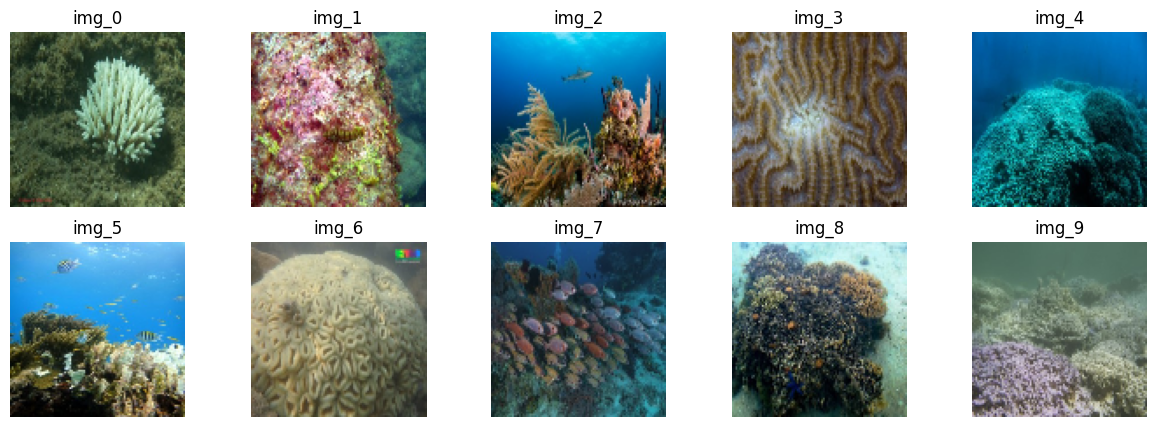

Augmented:


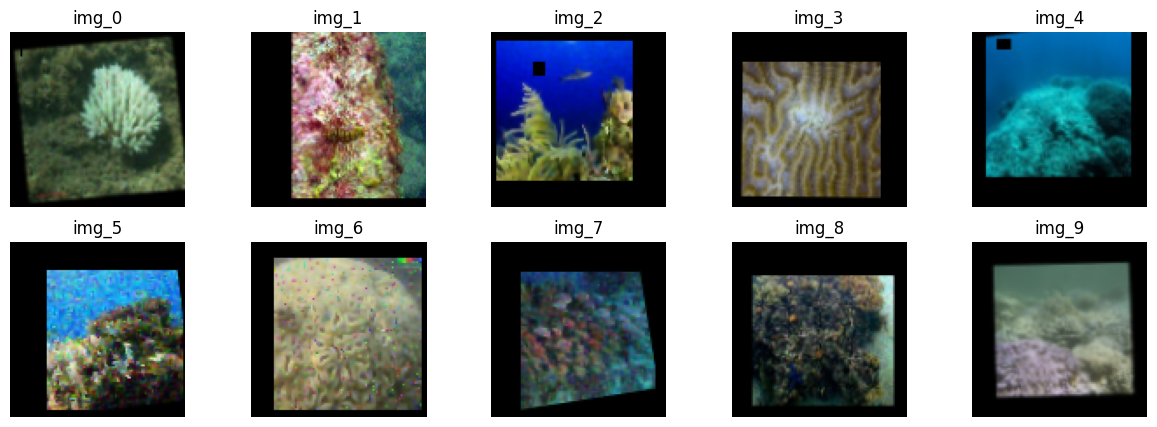

In [ ]:
# (: Execute me some times :)

# Get random 10 image coords
coords = random.sample(range(0, images.shape[0]), 10)


# Print images names
image_names = {i: img_paths[coord] for i, coord in enumerate(coords)}
print('Images:')
display(image_names)

# Print random 5 origin images
print('Origin:')
print_imgs(images, coords)


# Print random 5 augmented images
print('Augmented:')
print_imgs(new_images, coords)